<a href="https://colab.research.google.com/github/adast/TransResUNet/blob/master/TransResUNet_b16_fullres_infer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install necessary libraries, download dataset, download model

In [ ]:
! pip install ml_collections
! pip install torchinfo

! 7z x "/content/drive/MyDrive/Hand Segmentation/test.zip" -o./dataset/test '-xr!__MACOSX'
! mv dataset/test/test/* dataset/test/ && rm -rf dataset/test/test
! cp "/content/drive/MyDrive/Hand Segmentation/sample_submission.csv" sample_submission.csv

! git clone https://github.com/adast/TransResUNet

## Import libraries, set manaul seed, utility functions

In [16]:
# TransUnet
import sys
sys.path.insert(0, './TransResUNet')
from TransResUNet.models.trans_resunet import TransResUNet

# Pytorch
import torch
from torch import nn, optim
from torch.utils.data import Dataset, TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from torch.utils.tensorboard import SummaryWriter

import torchvision
from torchvision import transforms
from torchvision.utils import draw_segmentation_masks

from torchinfo import summary

# Others
import ml_collections
import os
import glob
import math
import numpy as np
import pandas as pd
import random
from tqdm.notebook import tqdm
from PIL import Image

# Make computations repeatable
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)

# Compute on gpu if available
device = "cuda" if torch.cuda.is_available() else "cpu"

# Run length encoding
def rle_encoding(x):
    '''
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten()==1)[0] # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

# Dice score
def dice_score(y_true, y_pred):
    return torch.sum(y_pred[y_true==1])*2.0 / (torch.sum(y_pred) + torch.sum(y_true))

# Run test data through model
def test(model, dataloader, device, return_image_masks=False):
    model.eval()
    predictions_labels = []

    outs = []
    rles = []
    with torch.no_grad(): 
        for batch in tqdm(dataloader, total=len(dataloader), desc="Testing on batches"):
            pixel_values = batch['pixel_values'].to(device)
            out = model(pixel_values)
            out = torch.sigmoid(out)
            out = (out > 0.5).float().detach().cpu()
            if return_image_masks:
                outs.append(out)

            # Apply run length encoding
            for i in range(out.shape[0]):
                rle = rle_encoding(out[i,:,:,:])
                rle_str = ' '.join(map(str, rle))
                rles.append(rle_str)

    if return_image_masks:
        return rles, torch.concat(outs)
    else:
        return rles

## Define test dataset class

In [2]:
class HandSegmentationTestDataset(Dataset):
    def __init__(self, paths):
        self.to_tensor = transforms.ToTensor()
        self.normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        self.paths = paths

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index: int):
        image = Image.open(self.paths[index]).convert('RGB')
        pixel_values = self.to_tensor(image)
        pixel_values = self.normalize(pixel_values)

        return {'pixel_values': torch.squeeze(pixel_values)}

## Initialize model, load checkpoint

In [3]:
def get_r50_b16_config():
    """Returns the ViT-B/16 configuration."""
    config = ml_collections.ConfigDict()
    
    config.image_size = (480, 640)
    config.n_classes = 1

    config.resnet = ml_collections.ConfigDict()
    # Using three bottleneck blocks results in a downscaling of 2^(1 + 3)=16 which
    # results in an effective patch size of /16.
    config.resnet.num_layers = (3, 4, 9)
    config.resnet.width_factor = 1
    
    config.transformer = ml_collections.ConfigDict()
    config.transformer.num_special_tokens = 1
    config.transformer.patch_size = 16
    config.transformer.hidden_size = 768
    config.transformer.mlp_dim = 3072
    config.transformer.num_heads = 12
    config.transformer.num_layers = 12
    config.transformer.attention_dropout_rate = 0.0
    config.transformer.dropout_rate = 0.1
    
    config.decoder = ml_collections.ConfigDict()
    config.decoder.head_channels = 512
    
    return config

# Initialize model
config = get_r50_b16_config()
model = TransResUNet(config).to(device)

# Load weights from checkpoint
checkpoint = torch.load('/content/drive/MyDrive/rucode_2021/segmentation/transunet-r50-b16-fullres/checkpoints/epoch-16_vl_0.00030_dice_0.99955.pt')
model.load_state_dict(checkpoint['model_state_dict'])

pre_trained_path is not specified, use this model with torch.load_state_dict only!


<All keys matched successfully>

## Make submission file

In [5]:
TEST_BATCH_SIZE = 8
NUM_WORKERS = 2

sample_submission = pd.read_csv('/content/sample_submission.csv')
test_dataset = HandSegmentationTestDataset(sample_submission['image'].values)
test_dataloader = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False)

rles = test(model, test_dataloader, device, return_image_masks=False)

sample_submission['segmentation'] = rles
sample_submission.to_csv('transresunet_b16-epoch-16_vl_0.00030_threshold-0.5.csv', index=False)

Testing on batches:   0%|          | 0/651 [00:00<?, ?it/s]

## Show test image with mask

Testing on batches:   0%|          | 0/1 [00:00<?, ?it/s]

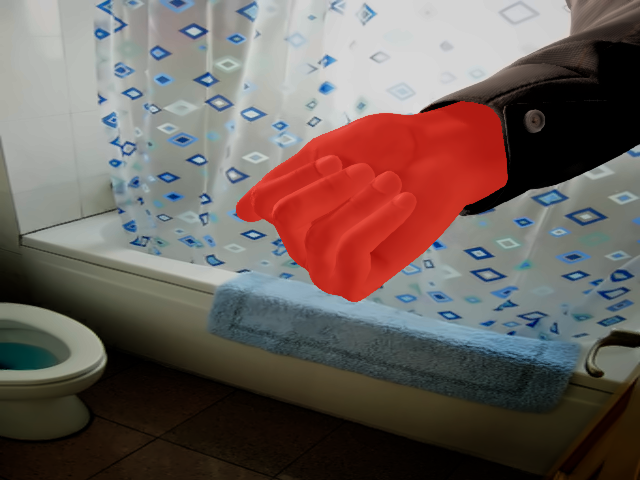

In [37]:
path = sample_submission['image'].values[0]

img = torchvision.io.read_image(path)

test_dataset = HandSegmentationTestDataset([path])
test_dataloader = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False)

_, mask = test(model, test_dataloader, device, return_image_masks=True)

img_new = draw_segmentation_masks(img, masks=mask[0].bool(), alpha=0.5, colors='red')
transforms.ToPILImage()(img_new)